** Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.**

**PROBLEM DEFINATION**

> How well can we measure the electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years with TIME SERIES

**DATA**

> This data is downloaded from kaggle notebook with the url https://www.kaggle.com/uciml/electric-power-consumption-data-set

> There are wo main dataset information

* This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).
 * Notes:
* (globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

* The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**EVALUATION**

> we’ll explore and build time series forecasting models

**FEATURES**

> Hamoye has provided a guild on how to go about with the project

In [1]:
# Importing required libraries for data loading
import pandas as pd
import numpy as np

In [2]:
# Importing required libraries for data visualisation
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima_model import ARIMA 
from fbprophet import Prophet

In [3]:
# Loading the dataset
power = pd.read_csv("../input/electric-power-consumption-data-set/household_power_consumption.txt", low_memory=False, sep=";",
                    header=0, infer_datetime_format=True, 
                    parse_dates={"datetime":[0,1]},index_col=["datetime"])


In [4]:
power.head().T


datetime,2006-12-16 17:24:00,2006-12-16 17:25:00,2006-12-16 17:26:00,2006-12-16 17:27:00,2006-12-16 17:28:00
Global_active_power,4.216,5.360,5.374,5.388,3.666
Global_reactive_power,0.418,0.436,0.498,0.502,0.528
Voltage,234.840,233.630,233.290,233.740,235.680
Global_intensity,18.400,23.000,23.000,23.000,15.800
Sub_metering_1,0.000,0.000,0.000,0.000,0.000
Sub_metering_2,1.000,1.000,2.000,1.000,1.000
Sub_metering_3,17,16,17,17,17


In [5]:
# Checking for missing data
power.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [6]:

count_na = 0
for values in power.values.tolist():
    for value in values:
        if value == '?':
            count_na += 1
        else:
            continue
            
print(count_na)

155874


In [7]:
power.replace("?", np.nan, inplace = True)
power.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
#convert to float

for column in power.select_dtypes(include=['object']).columns:
    power[[column]] = power[[column]].astype('float')

In [10]:
power.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [12]:
#time to use to fill the missing value
power= power.fillna(method='ffill')
power.isnull().sum()


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [13]:
# Making a copy of the original dataset to enable editting
power_edit = power.copy()

In [14]:
# Load the dataset to see if codes were correctly executed
power_edit.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [15]:
power_edit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [16]:
# Now check for missing data
power_edit.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [18]:
power_edit['active_energy_consumed'] = power_edit.apply(lambda row: row.Global_active_power  * 1000/60 - row.Sub_metering_1 - row.Sub_metering_2 - row.Sub_metering_3, axis=1)

In [19]:
#Let's check for any irregularities not captured by the isna/isnull function
count_na = 0
for values in power_edit.values.tolist():
    for value in values:
        if value == '?':
            count_na += 1
        else:
            continue
#Print the result
print('We have {} missing values not captured by isna/isnull command'.format(count_na))

We have 0 missing values not captured by isna/isnull command


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


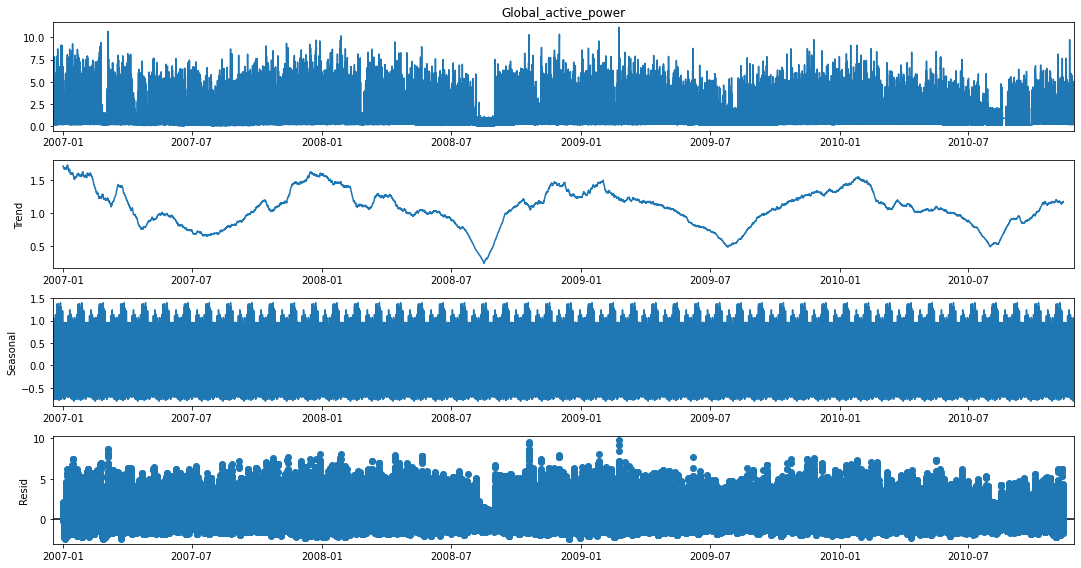

In [20]:

rcParams['figure.figsize'] = 15, 8

#60 mins, 24 hrs, 30 days = 43200
decompose_series = sm.tsa.seasonal_decompose(power['Global_active_power'], freq = 43200, model='additive')
decompose_series.plot()
plt.show()

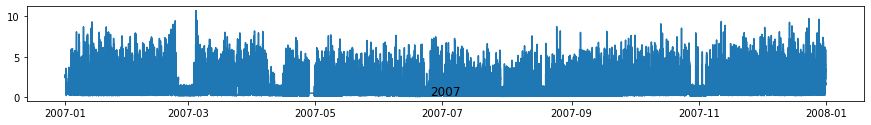

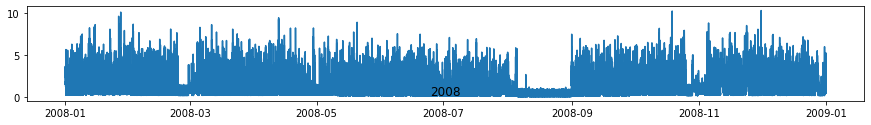

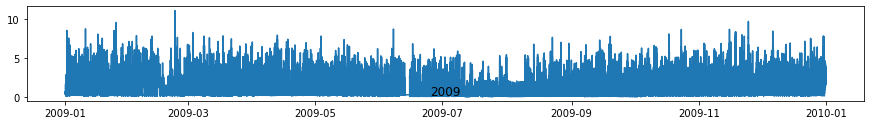

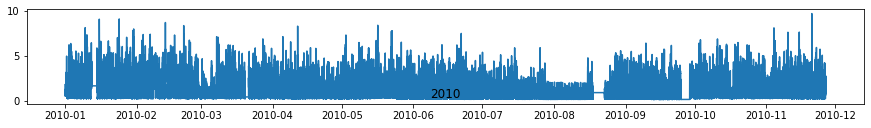

In [21]:
years = ["2007", "2008", "2009", "2010"]
plt.figure()

for i in range(len(years)):
    ax=plt.subplot(len(years), 1, i+1)
    year =years[i]
    result=power[str(year)] #yearly observations
    plt.plot(result["Global_active_power"])
    plt.title(str(year), y=0, loc="center")
    plt.show()

In [23]:

#Downsample 
power_dw = power.resample('D').mean()
power_dw.head(3)
power_dw.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [26]:
adf_result = adfuller(power_dw['Global_active_power'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')

for k, v in adf_result[4].items():   
  print(f'   {k}: {v}')

ADF Statistic: -3.7347586808460145
p-value: 0.0036499731073697398
No. of lags used: 22
No. of observations used : 1419
Critical Values:
   1%: -3.434966750462565
   5%: -2.8635789736973725
   10%: -2.5678555388041384


In [27]:
#Downsample 
power_monthly = power.resample('M').mean()
power_monthly.head(3)
power_monthly.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [28]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(power_monthly['Global_active_power'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')

for k, v in adf_result[4].items():   
  print(f'   {k}: {v}')

ADF Statistic: -4.616468415751828
p-value: 0.00012043644200149154
No. of lags used: 9
No. of observations used : 38
Critical Values:
   1%: -3.6155091011809297
   5%: -2.941262357486514
   10%: -2.6091995013850418


In [30]:
power_monthly = power_monthly.reset_index()
power_monthly.head(10)

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-31,1.901537,0.131400,241.440835,8.030969,1.251864,2.216312,7.409847
1,2007-01-31,1.546085,0.132683,240.904831,6.547133,1.264180,1.775851,7.383759
2,2007-02-28,1.401165,0.113634,240.519177,5.914911,1.180159,1.602282,6.704067
3,2007-03-31,1.318606,0.114747,240.513524,5.572890,1.361313,2.346819,6.504503
4,2007-04-30,0.856787,0.126467,239.127693,3.685574,0.974028,0.889282,4.386644
5,2007-05-31,0.985862,0.115343,235.178364,4.297464,1.696617,1.615860,5.139964
6,2007-06-30,0.826887,0.146355,238.877480,3.603718,1.381319,1.619074,4.372731
7,2007-07-31,0.668133,0.128498,237.678656,2.949122,0.964427,1.248499,3.468302
8,2007-08-31,0.763909,0.112822,237.936632,3.311537,0.812074,1.113642,5.050224
9,2007-09-30,0.969442,0.126019,239.423948,4.175130,1.223171,1.742569,5.240949


In [33]:
power_monthly= power_monthly.drop(columns = [ 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',])
power_monthly.head(10)


,datetime,Global_active_power
0,2006-12-31,1.901537
1,2007-01-31,1.546085
2,2007-02-28,1.401165
3,2007-03-31,1.318606
4,2007-04-30,0.856787
5,2007-05-31,0.985862
6,2007-06-30,0.826887
7,2007-07-31,0.668133
8,2007-08-31,0.763909
9,2007-09-30,0.969442


In [36]:
power_monthly.shape

power_monthly =power_monthly.rename(columns={"datetime": "ds", "Global_active_power": "y"}) 
power_monthly = power_monthly[["ds","y"]]
power_monthly.head(10)

,ds,y
0,2006-12-31,1.901537
1,2007-01-31,1.546085
2,2007-02-28,1.401165
3,2007-03-31,1.318606
4,2007-04-30,0.856787
5,2007-05-31,0.985862
6,2007-06-30,0.826887
7,2007-07-31,0.668133
8,2007-08-31,0.763909
9,2007-09-30,0.969442


In [39]:
from fbprophet import Prophet
#Modelling
model = Prophet()
#fit the model
model.fit(power_monthly)

In [40]:
#prediction for the next 12 months
future = model.make_future_dataframe(periods=12, freq='M') 
forecast = model.predict(future) 
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-31,1.170982,1.534025,1.731249,1.170982,1.170982,0.461804,0.461804,0.461804,0.461804,0.461804,0.461804,0.0,0.0,0.0,1.632786
1,2007-01-31,1.168197,1.399305,1.581703,1.168197,1.168197,0.323716,0.323716,0.323716,0.323716,0.323716,0.323716,0.0,0.0,0.0,1.491913
2,2007-02-28,1.165681,1.318619,1.522475,1.165681,1.165681,0.250739,0.250739,0.250739,0.250739,0.250739,0.250739,0.0,0.0,0.0,1.416420
3,2007-03-31,1.162896,1.164149,1.367892,1.162896,1.162896,0.103693,0.103693,0.103693,0.103693,0.103693,0.103693,0.0,0.0,0.0,1.266589
4,2007-04-30,1.160201,0.861275,1.051488,1.160201,1.160201,-0.202937,-0.202937,-0.202937,-0.202937,-0.202937,-0.202937,0.0,0.0,0.0,0.957264
5,2007-05-31,1.157416,0.994445,1.186005,1.157416,1.157416,-0.066267,-0.066267,-0.066267,-0.066267,-0.066267,-0.066267,0.0,0.0,0.0,1.091149
6,2007-06-30,1.154720,0.806769,1.013385,1.154720,1.154720,-0.243749,-0.243749,-0.243749,-0.243749,-0.243749,-0.243749,0.0,0.0,0.0,0.910971
7,2007-07-31,1.151935,0.602166,0.799918,1.151935,1.151935,-0.446053,-0.446053,-0.446053,-0.446053,-0.446053,-0.446053,0.0,0.0,0.0,0.705883
8,2007-08-31,1.149150,0.722806,0.922418,1.149150,1.149150,-0.327070,-0.327070,-0.327070,-0.327070,-0.327070,-0.327070,0.0,0.0,0.0,0.822080
9,2007-09-30,1.146455,0.821159,1.013988,1.146455,1.146455,-0.233261,-0.233261,-0.233261,-0.233261,-0.233261,-0.233261,0.0,0.0,0.0,0.913194


In [41]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2006-12-31,1.632786,1.534025,1.731249,1.170982,1.170982,1.170982
1,2007-01-31,1.491913,1.399305,1.581703,1.168197,1.168197,1.168197
2,2007-02-28,1.416420,1.318619,1.522475,1.165681,1.165681,1.165681
3,2007-03-31,1.266589,1.164149,1.367892,1.162896,1.162896,1.162896
4,2007-04-30,0.957264,0.861275,1.051488,1.160201,1.160201,1.160201
5,2007-05-31,1.091149,0.994445,1.186005,1.157416,1.157416,1.157416
6,2007-06-30,0.910971,0.806769,1.013385,1.154720,1.154720,1.154720
7,2007-07-31,0.705883,0.602166,0.799918,1.151935,1.151935,1.151935
8,2007-08-31,0.822080,0.722806,0.922418,1.149150,1.149150,1.149150
9,2007-09-30,0.913194,0.821159,1.013988,1.146455,1.146455,1.146455


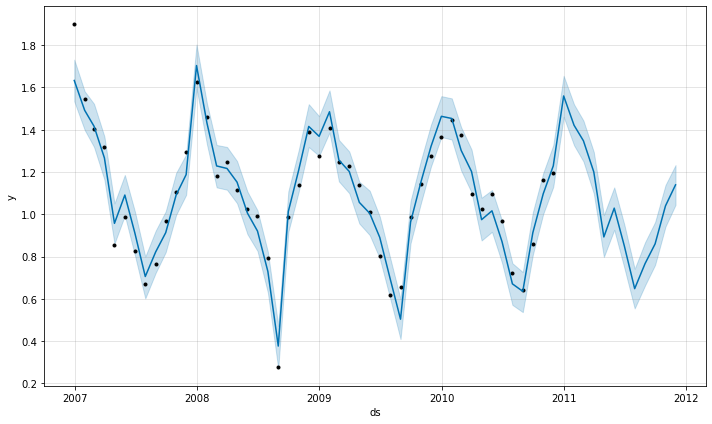

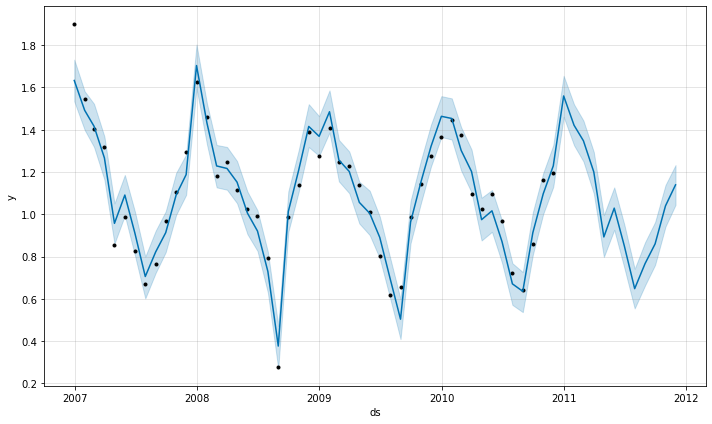

In [42]:
#plotting the forcast
model.plot(forecast)

In [43]:
power_dw = power_dw.reset_index()

power_dw= power_dw.drop(columns = [ 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
      'Sub_metering_3',])
power_dw.head(10)

,datetime,Global_active_power
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658
5,2006-12-21,1.192439
6,2006-12-22,1.625929
7,2006-12-23,3.314851
8,2006-12-24,1.770842
9,2006-12-25,1.904944


In [44]:

power_dw.shape

power_dw =power_dw.rename(columns={"datetime": "ds", "Global_active_power": "y"}) 
power_dw = power_dw[["ds","y"]]
power_dw.head(3)

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435


In [45]:
from fbprophet import Prophet

model2 = Prophet()
model2.fit(power_dw) 
    
#the next 30 days
future = model2.make_future_dataframe(periods=30, freq='D') 
forecast2 = model2.predict(future) 
forecast2.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,1.225106,1.365716,2.115600,1.225106,1.225106,0.510138,0.510138,0.510138,0.149837,0.149837,0.149837,0.360300,0.360300,0.360300,0.0,0.0,0.0,1.735243
1,2006-12-17,1.224272,1.329740,2.083278,1.224272,1.224272,0.485199,0.485199,0.485199,0.116017,0.116017,0.116017,0.369182,0.369182,0.369182,0.0,0.0,0.0,1.709471
2,2006-12-18,1.223439,1.115644,1.888624,1.223439,1.223439,0.283705,0.283705,0.283705,-0.094296,-0.094296,-0.094296,0.378001,0.378001,0.378001,0.0,0.0,0.0,1.507144
3,2006-12-19,1.222605,1.188719,1.953932,1.222605,1.222605,0.366476,0.366476,0.366476,-0.020029,-0.020029,-0.020029,0.386506,0.386506,0.386506,0.0,0.0,0.0,1.589082
4,2006-12-20,1.221772,1.245438,1.976410,1.221772,1.221772,0.392070,0.392070,0.392070,-0.002378,-0.002378,-0.002378,0.394449,0.394449,0.394449,0.0,0.0,0.0,1.613842
5,2006-12-21,1.220938,1.179759,1.884399,1.220938,1.220938,0.296453,0.296453,0.296453,-0.105141,-0.105141,-0.105141,0.401594,0.401594,0.401594,0.0,0.0,0.0,1.517391
6,2006-12-22,1.220105,1.231314,1.937216,1.220105,1.220105,0.363717,0.363717,0.363717,-0.044009,-0.044009,-0.044009,0.407727,0.407727,0.407727,0.0,0.0,0.0,1.583822
7,2006-12-23,1.219271,1.422474,2.177937,1.219271,1.219271,0.562495,0.562495,0.562495,0.149837,0.149837,0.149837,0.412657,0.412657,0.412657,0.0,0.0,0.0,1.781766
8,2006-12-24,1.218438,1.349884,2.116665,1.218438,1.218438,0.532246,0.532246,0.532246,0.116017,0.116017,0.116017,0.416229,0.416229,0.416229,0.0,0.0,0.0,1.750684
9,2006-12-25,1.217604,1.169248,1.915074,1.217604,1.217604,0.324029,0.324029,0.324029,-0.094296,-0.094296,-0.094296,0.418325,0.418325,0.418325,0.0,0.0,0.0,1.541633


In [47]:
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2006-12-16,1.735243,1.365716,2.115600,1.225106,1.225106,1.225106
1,2006-12-17,1.709471,1.329740,2.083278,1.224272,1.224272,1.224272
2,2006-12-18,1.507144,1.115644,1.888624,1.223439,1.223439,1.223439
3,2006-12-19,1.589082,1.188719,1.953932,1.222605,1.222605,1.222605
4,2006-12-20,1.613842,1.245438,1.976410,1.221772,1.221772,1.221772
...,...,...,...,...,...,...,...
1467,2010-12-22,1.487541,1.086355,1.851491,1.082192,1.081982,1.082463
1468,2010-12-23,1.389722,0.985990,1.724822,1.082206,1.081961,1.082503
1469,2010-12-24,1.454440,1.050390,1.826286,1.082220,1.081955,1.082542
1470,2010-12-25,1.650395,1.289596,2.042204,1.082233,1.081957,1.082587


In [ ]:
model.plot(forecast2)